# Quantum Error Correction circuito

In [1]:
# No olvidar que en "Google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime ipywidgets
except ImportError:
    print("NOT in colab")

In colab, let's install things...
INFO: pip is looking at multiple versions of qiskit-aer to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
import random
import scipy.linalg as la
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_bloch_multivector, array_to_latex, plot_state_qsphere

In [3]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    d_latex = psi.draw('latex', prefix=prefix)
    display(d_latex)
    #
    d_bloch = psi.draw('bloch')
    if isinstance(inches, (int,float)):
        if inches > 0:
            d_bloch.set_size_inches(inches, inches, forward=True)
            display(d_bloch)
    else:
        display(d_bloch)



<IPython.core.display.Latex object>

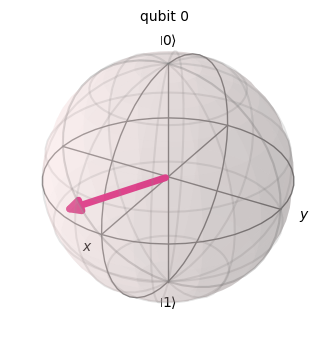

In [61]:
# Vamos a generar un vector de estado de un qubit a un estado aleatorio
rm = np.random.rand(2,1) + np.random.rand(2,1)*1j
rm = rm/la.norm(rm) # Normalizar
initial_state = Statevector(rm)

my_display_state_vector(initial_state, 4)

Vamos a implementar un circuito de corrección de error, de tipo BIT FLIT.

Ademas vamos a usar qubits ancilla para poder identificar donde se produjo el error.

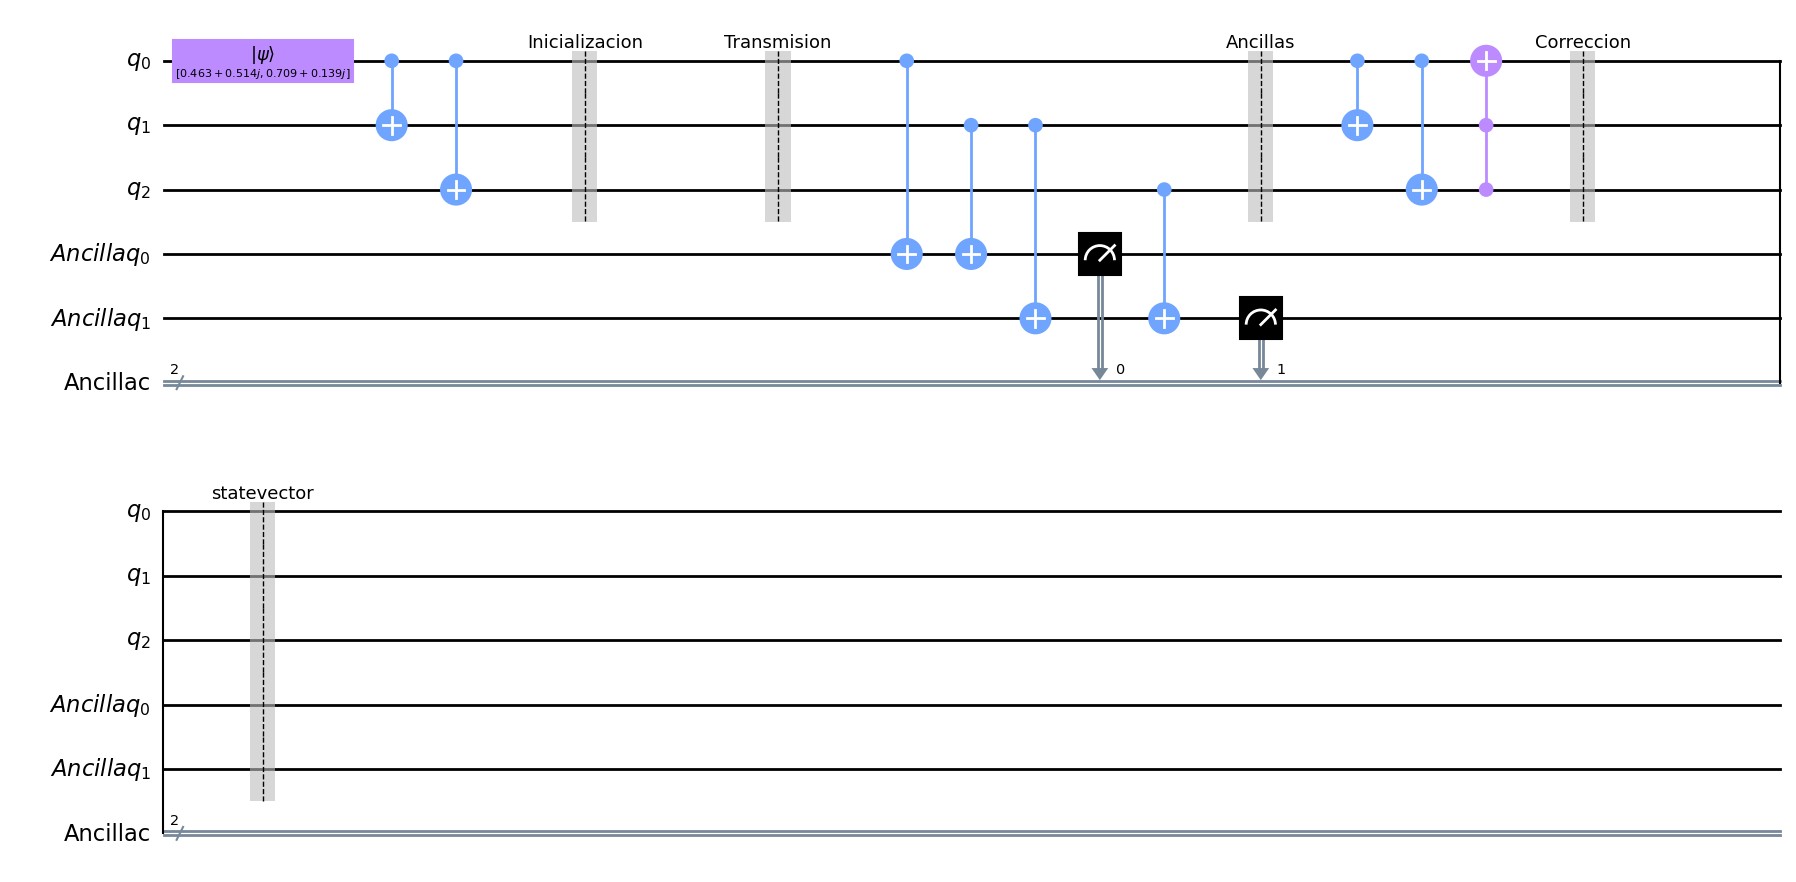

In [56]:
#Vamos a representar el circuito para bit flip correction con qubits ancilla

qreg_q = QuantumRegister(3, 'q')
qreg_ancillaq = QuantumRegister(2, 'Ancillaq')
creg_ancillac = ClassicalRegister(2, 'Ancillac')
circuit = QuantumCircuit(qreg_q,qreg_ancillaq ,creg_ancillac)

# Inicializamos el circuito
circuit.initialize(initial_state,qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.barrier(qreg_q[:],label="Inicializacion")
#Generamos un numero aleatorio para simular el ruido de transmision
#nrandom = random.random()
#nrandom = 0.05 #ejemplo error 1 qubit
#nrandom = 0.15 #ejemplo error 2 qubit
#nrandom = 0.25 #ejemplo error 3 qubit
nrandom = 0.35 #ejemplo sin error

if 0 <= nrandom <0.1:
  circuit.x(qreg_q[0])
  print("Error de transmision primer qubit, nramdom= ",nrandom)
elif 0.1 <= nrandom <0.2:
  circuit.x(qreg_q[1])
  print("Error de transmision segundo qubit nramdom= ",nrandom)
elif 0.2 <= nrandom <0.3:
  circuit.x(qreg_q[2])
  print("Error de transmision tercer qubit nramdom= ",nrandom)
circuit.barrier(qreg_q[:],label = "Transmision")
#Comprobacion del error con qubits ancilla
circuit.cx(qreg_q[0], qreg_ancillaq[0])
circuit.cx(qreg_q[1], qreg_ancillaq[0])
circuit.cx(qreg_q[1], qreg_ancillaq[1])
circuit.cx(qreg_q[2], qreg_ancillaq[1])
circuit.barrier(qreg_q[:],label="Ancillas")
#Volvemos al estado original os qubits auxiliares
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
#Deteccion de paridad posible error
circuit.measure(qreg_ancillaq[0], creg_ancillac[0])
circuit.measure(qreg_ancillaq[1], creg_ancillac[1])
#Correccion del posible error
circuit.ccx(qreg_q[1],qreg_q[2],qreg_q[0])
circuit.barrier(qreg_q[:],label="Correccion")
circuit.save_statevector()
circuit.draw('mpl')

Simulamos el circuito y comprobamos que el qubit 0 mantiene el estado $|\psi\rangle$.

<IPython.core.display.Latex object>

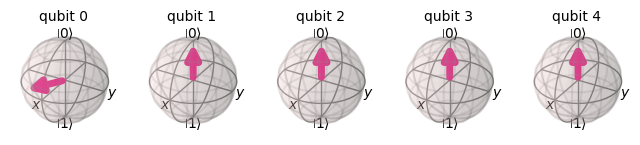

In [57]:
# Generamos una instancia del simulador;
# con "method" le especificamos el método de simulación
# Change the method to 'qasm_simulator' to get counts
simulador = AerSimulator(method='statevector')

# Transpilamos
circuit_t = transpile(circuit, backend=simulador)

# Ejecutamos la simulación, con un buen número de repeticiones
# (shots = 1000), ya que tenemos un medidor
job = simulador.run(circuit_t, shots=1)
result = job.result()
# con poderes podemos sacar el estado del qubit 2
final_state = result.get_statevector()
my_display_state_vector(final_state, 8)

In [60]:
#(initial_state[0],initial_state[1]) == (final_state[0],final_state[1])#Si no hay error
#(initial_state[0],initial_state[1]) == (final_state[14],final_state[15]):# Error de transmision en q0
#(initial_state[0],initial_state[1]) == (final_state[26],final_state[27]):# Error de transmision en q1
#(initial_state[0],initial_state[1]) == (final_state[20],final_state[21]):# Error de transmision en q2
if (initial_state[0],initial_state[1]) == (final_state[0],final_state[1]):# Comparacion para no Error de transmision en ningun q_i
  print("Estado inical igual al estado final")
elif la.norm((initial_state[0]-final_state[0],initial_state[1]-final_state[1])) < 0.00000001: # proximo al cero maquina, error de calculo
  print("Estado inical igual al estado final")
else:
  print("Hubo error: \n Estado inicial:",initial_state,"\n Estado final:" ,final_state)

Estado inical igual al estado final


Mediante los qubits ancilla, y sus mediciones, podemos comprobar si hubo en error donde se produjo.

In [24]:
counts = result.get_counts()
if '00' in counts:
  print("No hubo error de transmision")
elif '01' in counts:
  print("Hubo error de bit flip en el qubit 0")
elif '10' in counts:
  print("Hubo error de bit flip en el qubit 2")
elif '11' in counts:
  print("Hubo error de bit flip en el qubit 1")

No hubo error


El código anterior esta hecho para el caso de 1 simulación de transmisión.

A continuación vamos a hacer una simulación de $n=100$ transmisiones. Para repetiremos el circuito anterior de manera iterativa para distintos números aleatorios $nrandom \in [0,1]$.

In [85]:
def simulacion_bit_flip(n):
  acum_mensajes_erroneos= 0
  acum_mensajes_erroneos_mandados= 0
  for i in range(n):
    print("=============")
    print("Ronda ",i)
    # Vamos a generar un vector de estado de un qubit a un estado aleatorio
    rm = np.random.rand(2,1) + np.random.rand(2,1)*1j
    rm = rm/la.norm(rm) # Normalizar
    initial_state = Statevector(rm)
    #Vamos a representar el circuito para bit flip correction con qubits ancilla
    qreg_q = QuantumRegister(3, 'q')
    qreg_ancillaq = QuantumRegister(2, 'Ancillaq')
    creg_ancillac = ClassicalRegister(2, 'Ancillac')
    circuit = QuantumCircuit(qreg_q,qreg_ancillaq ,creg_ancillac)

    # Inicializamos el circuito
    circuit.initialize(initial_state,qreg_q[0])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[2])
    #Generamos un numero aleatorio para simular el ruido de transmision
    nrandom = random.random()
    #nrandom = 0.05 #ejemplo error 1 qubit
    #nrandom = 0.15 #ejemplo error 2 qubit
    #nrandom = 0.25 #ejemplo error 3 qubit
    if 0 <= nrandom <0.1:
      circuit.x(qreg_q[0])
      print("Error de transmision primer qubit, nramdom= ",nrandom)
      acum_mensajes_erroneos_mandados +=1
    elif 0.1 <= nrandom <0.2:
      circuit.x(qreg_q[1])
      print("Error de transmision segundo qubit nramdom= ",nrandom)
      acum_mensajes_erroneos_mandados +=1
    elif 0.2 <= nrandom <0.3:
      circuit.x(qreg_q[2])
      print("Error de transmision tercer qubit nramdom= ",nrandom)
      acum_mensajes_erroneos_mandados +=1
    #Comprobacion del error con qubits ancilla
    circuit.cx(qreg_q[0], qreg_ancillaq[0])
    circuit.cx(qreg_q[1], qreg_ancillaq[0])
    circuit.cx(qreg_q[1], qreg_ancillaq[1])
    circuit.cx(qreg_q[2], qreg_ancillaq[1])
    #Volvemos al estado original os qubits auxiliares
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[2])
    #Deteccion de paridad posible error
    circuit.measure(qreg_ancillaq[0], creg_ancillac[0])
    circuit.measure(qreg_ancillaq[1], creg_ancillac[1])
    #Correccion del posible error
    circuit.ccx(qreg_q[1],qreg_q[2],qreg_q[0])
    circuit.save_statevector()
    # Generamos una instancia del simulador;
    # con "method" le especificamos el método de simulación
    # Change the method to 'qasm_simulator' to get counts
    simulador = AerSimulator(method='statevector')

    # Transpilamos
    circuit_t = transpile(circuit, backend=simulador)

    # Ejecutamos la simulación, con un buen número de repeticiones
    # (shots = 1000), ya que tenemos un medidor
    job = simulador.run(circuit_t, shots=1)
    result = job.result()
    # con poderes podemos sacar el estado del qubit 2
    final_state = result.get_statevector()
    #Vamos a comprobar si finalstate=inicialstate
    counts = result.get_counts()
    if '00' in counts:
      if (initial_state[0],initial_state[1]) == (final_state[0],final_state[1]):# Comparacion para no Error de transmision en ningun q_i
        print("Estado inical igual al estado final")
      elif la.norm(((initial_state[0]-final_state[0]),(initial_state[1]-final_state[1]))) < 0.00000001: # proximo al cero maquina, error de calculo
        print("Estado inical igual al estado final")
      else:
        print("Hubo error: \n Estado inicial:",(initial_state[0],initial_state[1]),"\n Estado final:" ,(final_state[0],final_state[1]))
        acum_mensajes_erroneos +=1
      print("No hubo error de transmision")
    elif '01' in counts:
      if (initial_state[0],initial_state[1]) == (final_state[14],final_state[15]):# Comparacion para Error de transmision en q0
        print("Estado inical igual al estado final")
      elif la.norm(((initial_state[0]-final_state[14]),(initial_state[1]-final_state[15]))) < 0.00000001: # proximo al cero maquina, error de calculo
        print("Estado inical igual al estado final")
      else:
        print("Hubo error: \n Estado inicial:",(initial_state[0],initial_state[1]),"\n Estado final:" ,(final_state[14],final_state[15]))
        acum_mensajes_erroneos +=1
      print("Hubo error de bit flip en el qubit 0")
    elif '10' in counts:
      if (initial_state[0],initial_state[1]) == (final_state[20],final_state[21]):# Comparacion para Error de transmision en q2
        print("Estado inical igual al estado final")
      elif la.norm((initial_state[0]-final_state[20],initial_state[1]-final_state[21])) < 0.00000001: # proximo al cero maquina, error de calculo
        print("Estado inical igual al estado final")
      else:
        print("Hubo error: \n Estado inicial:",(initial_state[0],initial_state[1]),"\n Estado final:" ,(final_state[20],final_state[21]))
        acum_mensajes_erroneos +=1
      print("Hubo error de bit flip en el qubit 2")
    elif '11' in counts:
      if (initial_state[0],initial_state[1]) == (final_state[26],final_state[27]):# Comparacion para Error de transmision en q1
        print("Estado inical igual al estado final")
      elif la.norm((initial_state[0]-final_state[26],initial_state[1]-final_state[27])) < 0.00000001: # proximo al cero maquina, error de calculo
        print("Estado inical igual al estado final")
      else:
        print("Hubo error: \n Estado inicial:",(initial_state[0],initial_state[1]),"\n Estado final:" ,(final_state[26],final_state[27]))
        acum_mensajes_erroneos +=1
      print("Hubo error de bit flip en el qubit 1")
    print("=============")
  print("\n Numero total de mensajes con erroneos de transmision mandados:",acum_mensajes_erroneos_mandados,"\n Numero total de mensajes con erroneos de transmision mandados sin corregir:",acum_mensajes_erroneos)
  return("Fin de la simulacion")
simulacion_bit_flip(100)


Ronda  0
Estado inical igual al estado final
No hubo error de transmision
Ronda  1
Estado inical igual al estado final
No hubo error de transmision
Ronda  2
Estado inical igual al estado final
No hubo error de transmision
Ronda  3
Estado inical igual al estado final
No hubo error de transmision
Ronda  4
Error de transmision tercer qubit nramdom=  0.27931783381859754
Estado inical igual al estado final
Hubo error de bit flip en el qubit 2
Ronda  5
Estado inical igual al estado final
No hubo error de transmision
Ronda  6
Estado inical igual al estado final
No hubo error de transmision
Ronda  7
Error de transmision primer qubit, nramdom=  0.09657892445440419
Estado inical igual al estado final
Hubo error de bit flip en el qubit 0
Ronda  8
Estado inical igual al estado final
No hubo error de transmision
Ronda  9
Error de transmision segundo qubit nramdom=  0.15205533657293957
Estado inical igual al estado final
Hubo error de bit flip en el qubit 1
Ronda  10
Estado inical igual al estado fi

'Fin de la simulacion'

# Conclusión:
Se han mandado aproximadamente un $30$% de mensajes con error (este porcentaje se podría ajustar en el código para que fuera mayor/menor) y todos ellos se han conseguido corregir para conseguir que el estado final sea igual al inicial.

Para implementar el de phase flip sería similar, teniendo en cuanta que el error de transmisión en este caso es aplicar una puerta $Z$ en vez de una puerta $X$. Podríamos hacer uso de la equivalencia $H X H \equiv Z$ para ajustar el circuito.

*Trabajo hecho por Manuel Enciso Martinez*